In [9]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute, IBMQ, transpile
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.tools import job_monitor

from qiskit.circuit.library import EfficientSU2

from qiskit.algorithms.optimizers import SPSA
from qiskit.quantum_info import Pauli, Operator
from qiskit.providers.models import BackendProperties

from qiskit.providers.fake_provider import FakeMumbai
from qiskit.compiler import transpile
import qiskit

import numpy as np
from skquant.opt import minimize
from scipy.stats import pearsonr
from numpy.linalg import eigh
import matplotlib.pyplot as plt
import pickle
import copy
import csv

from VarSaw.term_grouping import *
import VarSaw.Reconstruction_Functions as RF

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Sampler
from qiskit_aer.noise import NoiseModel

<ipython-input-9-767d10cbfd96>:8: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import SPSA


### Define the backend, noise model and the simulator


In [ ]:
backend = FakeMumbai()
noise_model = NoiseModel.from_backend(backend)
dm_simulator = Aer.get_backend('aer_simulator_density_matrix')

In [ ]:
noiseless_dm = noiseless_job.result().data(cc)['density_matrix']
noisy_dm = noisy_job.result().data(cc)['density_matrix']

In [ ]:
noisy_dm.data

### Mitiq Testing ###

In [ ]:
import qiskit
from qiskit_ibm_provider import IBMProvider

import mitiq
from mitiq import zne
from mitiq.zne.inference import RichardsonFactory

In [10]:
############################################### Get reference energy ##############################################
def get_ref_energy(coeffs, paulis):
    '''
    Args:
    coeffs: The coeffs of the puali tensor products
    paulis: The pauli tensors
    '''   
    # the final operation
    final_op = None

    for ii, el in enumerate(paulis):
        if ii == 0:
            final_op = coeffs[ii]*Operator(Pauli(el))
        else:
            final_op += coeffs[ii]*Operator(Pauli(el))
   
    # compute the eigenvalues
    evals, evecs = eigh(final_op.data)
   
    # get the minimum eigenvalue
    min_eigenval = np.min(evals)
    return min_eigenval

########################################### Compute expectations ################################################## 

def compute_expectations(all_counts):
    '''
    Args:
    all_counts: All the counts for which we want to compute expectations
    
    Returns:
    All the expectation values
    
    '''
    all_expectation_vals = []
    for idx, count in enumerate(all_counts): 
        sum_counts = sum(list(count.values()))
        exp_val = 0
        for el in count:
            
            # allot the sign to the element
            sign = 1
            if el.count('1')%2 == 1:
                sign = -1
            
            # add to expectation value
            exp_val += sign*(count[el]/sum_counts)
        
        all_expectation_vals.append(exp_val)
            
    return all_expectation_vals

####################################################################################################################
def get_ref_energy(coeffs, paulis):
    '''
    Args:
    coeffs: The coeffs of the puali tensor products
    paulis: The pauli tensors
    '''   
    # the final operation
    final_op = None

    for ii, el in enumerate(paulis):
        if ii == 0:
            final_op = coeffs[ii]*Operator(Pauli(el))
        else:
            final_op += coeffs[ii]*Operator(Pauli(el))
   
    # compute the eigenvalues
    evals, evecs = eigh(final_op.data)
   
    # get the minimum eigenvalue
    min_eigenval = np.min(evals)
    return min_eigenval

###################################################################################################################
def give_paulis_and_coeffs(hamiltonian, num_qubits):
    '''
    hamiltonian: A list containing all hamiltonian terms along with their weights
    num_qubits: The number of qubits in the hamiltonian
    '''
    paulis = []
    coeffs = []
    
    for idx, term in enumerate(hamiltonian):
        
        #the coefficient
        coeffs.append(term[0])
        
        #the pauli string
        pauli_string = num_qubits*'I'
        all_gates = term[1]
        #print(non_id_gates)
        
        for _, gate in enumerate(all_gates):
            pauli = gate[0]
            location = int(gate[1])
            #print('location: ', location, 'pauli_string: ', pauli_string, 'pauli: ', pauli)
            pauli_string = pauli_string[0:location] + pauli + pauli_string[location+1:]
            #print(pauli_string, len(pauli_string))
        
        paulis.append(pauli_string)
    
    return coeffs, paulis

##################### Function to create parameterized quantum state ################################
def quantum_state_preparation(circuit, parameters):
    '''
    Args:
    circuit: The input circuit to which we append the parameterized state
    parameters: The parameters of the rotations
    
    Returns:
    Circuit with /home/siddharthdangwal/JigSaw+VQE/Data/Experiment 2/TFIM-4-full/noisy_jigsaw_params.csvthe ansatz for a generalized state appended to it
    '''
    num_qubits = circuit.num_qubits
    
    #the number of repetitions of a general ansatz block
    p = (len(parameters)/(2*num_qubits)) - 1
    
    #make sure that p is an integer and then change the format
    assert int(p) == p
    p = int(p)
    
    #create an EfficientSU2 ansatz
    ansatz = EfficientSU2(num_qubits = num_qubits, entanglement = 'full', reps = p, insert_barriers = True)
    ansatz.assign_parameters(parameters = parameters, inplace = True)
    circuit.compose(ansatz, inplace = True)
    
    return circuit

##################### Prepare a VQE circuit for a given single-element hamiltonian ################################
def vqe_circuit(n_qubits, parameters, hamiltonian):
    '''
    Args:
    n_qubits: The number of qubits in the circuit
    parameters: The parameters for the vqe circuit
    hamiltonian: The hamiltonian string whose expectation would be measured
    using this circuit
    
    Returns:
    The VQE circuit for the given Pauli tensor hamiltonian 
    '''
    qr = QuantumRegister(n_qubits)
    cr = ClassicalRegister(n_qubits)
    circuit = QuantumCircuit(qr, cr)
    
    #append the circuit with the state preparation ansatz
    circuit = quantum_state_preparation(circuit, parameters)
    
    #add the measurement operations
    for i, el in enumerate(hamiltonian):
        if el == 'I':
            #no measurement for identity
            continue
        elif el == 'Z':
            circuit.measure(qr[i], cr[i])
        elif el == 'X':
            circuit.u(np.pi/2, 0, np.pi, qr[i])
            circuit.measure(qr[i], cr[i])
        elif el == 'Y':
            circuit.u(np.pi/2, 0, np.pi/2, qr[i])
            circuit.measure(qr[i], cr[i])
    
    return circuit


################# scaling - helper functions ####################################################################
def apply_operator(all_scaled_ansatz, pauli_op, layout_dict):
    '''
    Args:
    all_scaled_ansatz: A list of ansatz scaled at different noise factors
    pauli_op: The Pauli operator whose expectation we want to obtain
    layout_dict: The mapping from virtual to physical done on the ansatz
    '''
    ansatz_with_measurement = []
    for idx, ansatz in enumerate(all_scaled_ansatz):
        
        # apply all the operations to change basis on the ansatz
        for pauli_idx, pauli in enumerate(pauli_op):
            if pauli == 'I':
                continue
            elif pauli == 'Z':
                ansatz.measure(layout_dict[pauli_idx], pauli_idx)
            elif pauli == 'X':
                ansatz.rz(np.pi/2, layout_dict[pauli_idx])
                ansatz.sx(layout_dict[pauli_idx])
                ansatz.rz(np.pi/2, layout_dict[pauli_idx])
                ansatz.measure(layout_dict[pauli_idx], pauli_idx)
            elif pauli == 'Y':
                ansatz.sx(layout_dict[pauli_idx])
                ansatz.rz(np.pi/2, layout_dict[pauli_idx])
                ansatz.measure(layout_dict[pauli_idx], pauli_idx)
        
        # add this circuit to the list of circuits with measurements
        ansatz_with_measurement.append(ansatz)
    
    return ansatz_with_measurement


############### executor ############################################################

def ibmq_executor(circuits, backend, shots: int = 8192) -> float:
    """Returns the expectation value to be mitigated.

    Args:
        circuit: Circuit to run.
        shots: Number of times to execute the circuit to compute the expectation value.
    """
    
    max_experiments = backend.configuration().max_experiments
    num_jobs = int(np.ceil(len(circuits)/max_experiments))
    
    all_jobs = []
    for job_idx in range(num_jobs):
        circs_for_job = circuits[job_idx*max_experiments:(job_idx+1)*max_experiments]
        job = qiskit.execute(
            circs_for_job,
            backend=backend,
            optimization_level=0,
            shots=shots
        )
        all_jobs.append(job)
    
    # check if all jobs have been completed or not
    while True:
        combined_job_status = True
        for j in all_jobs:
            combined_job_status = combined_job_status and (str(j.status()) == 'JobStatus.DONE')
        
        if combined_job_status:
            break
    
    # combine all the results from all jobs
    all_counts = []
    for job in all_jobs:
        all_counts = all_counts + job.result().get_counts()
    
    # Convert raw measurement counts to expectation values
    all_expectation_vals = []
    for count in all_counts:
        sum_counts = sum(list(counts.values()))
        exp_val = 0
        for el in count:
            
            # allot the sign to the element
            sign = 1
            if el.count('1')%2 == 1:
                sign = -1
            
            # add to expectation value
            exp_val += sign*(count[el]/sum_counts)
        
        all_expectation_vals.append(exp_val)
            
    return all_expectation_vals

def job_sender(circuits, backend, shots):
    
    max_experiments = backend.configuration().max_experiments
    num_jobs = int(np.ceil(len(circuits)/max_experiments))
    simulator = Aer.get_backend('qasm_simulator')
    
    all_jobs = []
    for job_idx in range(num_jobs):
        circs_for_job = circuits[job_idx*max_experiments:(job_idx+1)*max_experiments]
        job = qiskit.execute(
            circs_for_job,
            backend=backend,
            optimization_level=0,
            shots=shots
        )
        all_jobs.append(job)
    
    return all_jobs

def job_sender_noise_model(circuits, backend, shots):
    
    
    noise_model = NoiseModel.from_backend(backend)
    simulator = Aer.get_backend('qasm_simulator')
    all_jobs = []
    
    job = qiskit.execute(
        circuits,
        backend=simulator,
        noise_model=noise_model,
        optimization_level=0,
        shots=shots
    )
    
    all_jobs.append(job)

    return all_jobs
    
def expectation_calculator(all_jobs, shots_per_circ):
    
    # check if all jobs have been completed or not
    while True:
        combined_job_status = True
        for j in all_jobs:
            combined_job_status = combined_job_status and (str(j.status()) == 'JobStatus.DONE')
        
        if combined_job_status:
            break
    
    # combine all the results from all jobs
    all_counts = []
    for job in all_jobs:
        job_length = len(job.result().results)
        for count_idx in range(job_length):
            try:
                all_counts.append(job.result().get_counts(count_idx))
            except:
                print('Exception encountered!')
                all_counts.append({n_qubits*'0':shots_per_circ})
    
    # Convert raw measurement counts to expectation values
    all_expectation_vals = []
    for idx, count in enumerate(all_counts): 
        sum_counts = sum(list(count.values()))
        exp_val = 0
        for el in count:
            
            # allot the sign to the element
            sign = 1
            if el.count('1')%2 == 1:
                sign = -1
            
            # add to expectation value
            exp_val += sign*(count[el]/sum_counts)
        
        all_expectation_vals.append(exp_val)
            
    return all_expectation_vals

### Define the problem hamiltonian and get the Paulis ###

In [23]:
hamiltonian_string = '/u/vqezne/Internship/VarSaw/vqe-term-grouping-master/hamiltonians/CH4_sto-3g_BK_grnd_AS3.txt'
hamiltonian_string_elements = hamiltonian_string.split('/')
hamil = parseHamiltonian(hamiltonian_string)

#get the number of qubits in the hamiltonian
max_length = 0
for i in hamil:
    if int(i[1][-1][1]) + 1 > max_length:
        max_length = int(i[1][-1][1]) + 1

#Number of qubits in the hamiltonian
n_qubits = max_length

# number of repetitions
p = 1

#get paulis and coefficients
coeffs, paulis = give_paulis_and_coeffs(hamil, n_qubits)
n_terms = len(paulis)
paulis = paulis[1:n_terms]
coeffs = coeffs[1:n_terms]

In [ ]:
paulis

### Get different initialization points ###

In [ ]:
# initialize the problem to diff parameter sets
# we choose 10 points

np.random.seed(0)
all_init_points = np.random.randn(2*n_qubits*(p+1), 10)*np.pi

### Define the backend ###

In [ ]:
#provider = IBMProvider()
#backend = provider.get_backend('ibm_hanoi')
backend = FakeMumbai()

In [ ]:
print(backend.configuration().basis_gates)
print(backend.configuration().max_experiments, backend.configuration().max_shots)

### Define the scales ###

In [16]:
scales = [1, 10, 20, 30, 40, 50, 60]
scales = [1, 3, 5, 7, 9, 11]

### Create scaled VQE circuits for the different initializations ###

In [ ]:
# Get an ansatz for diff circuits. 
# If there are 'n' diff initializations, there would be 'n' ansatz
vqe_ansatz_for_diff_init = []
num_init = 10
for init_idx in range(num_init):
    init_params = all_init_points[:, init_idx]
    qr = QuantumRegister(n_qubits)
    cr = ClassicalRegister(n_qubits)
    circuit = QuantumCircuit(qr, cr)
    ansatz = quantum_state_preparation(circuit, init_params)
    vqe_ansatz_for_diff_init.append(ansatz)

# Transpile each ansatz, then scale
transpiled_vqe_ansatz_for_diff_init = transpile(vqe_ansatz_for_diff_init, backend, optimization_level = 3, seed_transpiler = 0)

# get the virtual-to-physical mapping (as a python dictionary) for each initialization
# the key in the mapping corresponds to the virtual qubit index
# the value in the mapping corresponds to the physical qubit index
layouts_for_diff_init = []
for init_idx in range(num_init):
    v2p_simplified = {}
    v2p_mapping = transpiled_vqe_ansatz_for_diff_init[init_idx]._layout.initial_layout.get_virtual_bits()
    all_relevant_keys = list(v2p_mapping.keys())[0:vqe_ansatz_for_diff_init[init_idx].num_qubits]
    for key in all_relevant_keys:
        assert (key.register.name != 'ancilla') # make sure that the key we are indexing is not an ancilla key
        v2p_simplified[key.index] = v2p_mapping[key]
    
    # add the simplified v2p mapping dict for given 
    # initialization to the list of different layouts
    print(init_idx, v2p_simplified)
    layouts_for_diff_init.append(v2p_simplified)

# scale all the ansatz now and add the measurements
# the key in the 'all_scaled_circs' dictionary corresponds the initialization index. 
# The value corresponds to a dictionary called 'pauli_to_scaled_circs'
# The 'pauli_to_scaled_circs' dictionary has a Pauli string as its key.
# The value is a list of scaled circuits corresponding to that Pauli index

all_scaled_circs = {}
for init_idx in range(num_init):
    layout_dict = layouts_for_diff_init[init_idx]
    transpiled_ansatz = transpiled_vqe_ansatz_for_diff_init[init_idx]
    
    # get scaled versions of the transpiled ansatz
    all_scaled_ansatz = []
    for scale_val in scales:
        scaled_ansatz_for_scale_val = mitiq.zne.scaling.folding.fold_all(transpiled_ansatz, scale_val)
        all_scaled_ansatz.append(scaled_ansatz_for_scale_val)
    
    # apply all the pauli operators to get the pauli_to_scaled_circ dict
    pauli_to_scaled_circ = {}
    for pauli_idx, pauli_op in enumerate(paulis):
        print(pauli_idx, pauli_op)
        pauli_to_scaled_circ[pauli_op] = apply_operator(all_scaled_ansatz, pauli_op, layout_dict)
    
    # insert the 'pauli_to_scaled_circ' dictionary in the 'all_scaled_circs' dict
    all_scaled_circs[init_idx] = pauli_to_scaled_circ

### Unroll the scaled circuits to execute on a processor ###

In [ ]:
all_scaled_circs_unrolled = []
for init_idx in range(num_init):
    all_circs_dict = all_scaled_circs[init_idx]
    for pauli in all_circs_dict:
        all_scaled_circs_unrolled += all_circs_dict[pauli]
        
assert (len(all_scaled_circs_unrolled) == len(list(all_scaled_circs[0].values())[0])*len(paulis)*num_init)

In [ ]:
all_jobs = job_sender(all_scaled_circs_unrolled, backend, 100000)

In [ ]:
all_exps = expectation_calculator(all_jobs, 100000)

In [ ]:
all_counts = []
for job in all_jobs:
    job_length = len(job.result().results)
    for count_idx in range(job_length):
        try:
            all_counts.append(job.result().get_counts(count_idx))
        except:
            print('Exception encountered!')
            all_counts.append({n_qubits*'0':100000})

In [ ]:
def get_scaled_exp_dict_dict(num_inits, scales, paulis, all_exps):
    '''
    '''
    
    num_elements_per_init = len(all_exps)/len(num_inits)
    assert (int(num_elements_per_init) == num_elements_per_init)
    num_elements_per_init = int(num_elements_per_init)
    
    scaled_exps_dict_dict = { _ : {p:[] for p in paulis} for _ in range(num_inits)}
    
    for i in range(num_inits):
        num_vals_per_init = all_exps[i*num_elements_per_init: (i+1)*num_elements_per_init]
        length_per_pauli = len(scales)
        for pauli_idx, pauli_op in enumerate(paulis):
            scaled_exps_dict_dict[i][pauli_op] = num_vals_per_init[pauli_idx*length_per_pauli : (pauli_idx + 1)*length_per_pauli]
    
    return scaled_exps_dict_dict

In [ ]:
scaled_exps_dict_dict = get_scaled_exp_dict_dict(num_init, scales, paulis, all_exps)

# Noisy VQE+ZNE experiment on a statevector/density matrix simulator #

### Create scaled VQE circuits for the different initializations ###

In [ ]:
def alter_properties_dict(backend, scaling_factor):
    '''
    Args:
    backend: The qiskit backend whose properties dictionary we have to modify
    scaling_factor: The factor by which we want to scale the properties
    
    Returns:
    A new dictionary with scaled noise parameters 
    '''
    import copy
    
    conf_dict = backend.configuration().to_dict()
    prop_dict = backend.properties().to_dict()
    
    new_prop_dict = copy.deepcopy(prop_dict)
    
    #alter the qubit based properties - readout error rates and t1, t2 times
    qubits = prop_dict['qubits']
    props_to_change = ['T1', 'T2', 'readout_error', 'prob_meas0_prep1', 'prob_meas1_prep0']
    for idx, qubit in enumerate(qubits):
        
        #a qubit is represented by 8 properties
        assert len(qubit) == 8
        
        for idx2, prop in enumerate(qubit):
            if prop['name'] in props_to_change:
                
                if prop['name'] == 'T1' or prop['name'] == 'T2':
                    new_prop_value = prop['value']*(1/scaling_factor)
                    #print(prop['name'], prop['value'], new_prop_value)
                else:
                    new_prop_value = prop['value']*scaling_factor
                    #print(prop['name'], prop['value'], new_prop_value)
                
                new_prop_dict['qubits'][idx][idx2]['value'] = new_prop_value
                
    #alter the gate based properties - gate error
    gates = prop_dict['gates']
    for idx, gate in enumerate(gates):
        
        for idx2 in range(len(gate['parameters'])):
            
            #a gate is represented by a dicrionary of 4 items
            gate_error_dict = gate['parameters'][idx2]

            #change the value of the gate error
            if gate_error_dict['name'] == 'gate_error':
                new_gate_error_val = gate_error_dict['value']*scaling_factor
                new_prop_dict['gates'][idx]['parameters'][idx2]['value'] = new_gate_error_val
                #print(gate_error_dict['name'], gate_error_dict['value'], new_gate_error_val)
    
    return new_prop_dict

### Define the scales ###

In [ ]:
scales = [1, 10, 20, 30, 40, 50, 60]
#scales = [1, 3, 5, 7, 9, 11]

In [ ]:
# Get an ansatz for diff circuits. 
# If there are 'n' diff initializations, there would be 'n' ansatz
vqe_ansatz_for_diff_init = []
num_init = 10
for init_idx in range(num_init):
    init_params = all_init_points[:, init_idx]
    qr = QuantumRegister(n_qubits)
    cr = ClassicalRegister(n_qubits)
    circuit = QuantumCircuit(qr, cr)
    ansatz = quantum_state_preparation(circuit, init_params)
    vqe_ansatz_for_diff_init.append(ansatz)

# Transpile each ansatz, then scale
backend_basis_gates = backend.configuration().basis_gates
transpiled_vqe_ansatz_for_diff_init = transpile(vqe_ansatz_for_diff_init, basis_gates = backend_basis_gates, optimization_level = 3, seed_transpiler = 0)
#transpiled_vqe_ansatz_for_diff_init = transpile(vqe_ansatz_for_diff_init, backend = backend, optimization_level = 3, seed_transpiler = 0)


# get the virtual-to-physical mapping (as a python dictionary) for each initialization
# the key in the mapping corresponds to the virtual qubit index
# the value in the mapping corresponds to the physical qubit index

# layouts_for_diff_init = []
# for init_idx in range(num_init):
#     v2p_simplified = {}
#     v2p_mapping = transpiled_vqe_ansatz_for_diff_init[init_idx]._layout.initial_layout.get_virtual_bits()
#     all_relevant_keys = list(v2p_mapping.keys())[0:vqe_ansatz_for_diff_init[init_idx].num_qubits]
#     for key in all_relevant_keys:
#         assert (key.register.name != 'ancilla') # make sure that the key we are indexing is not an ancilla key
#         v2p_simplified[key.index] = v2p_mapping[key]
    
#     # add the simplified v2p mapping dict for given 
#     # initialization to the list of different layouts
#     print(init_idx, v2p_simplified)
#     layouts_for_diff_init.append(v2p_simplified)

# scale all the ansatz now and add the measurements
# the key in the 'all_scaled_circs' dictionary corresponds the initialization index. 
# The value corresponds to a dictionary called 'pauli_to_scaled_circs'
# The 'pauli_to_scaled_circs' dictionary has a Pauli string as its key.
# The value is a list of scaled circuits corresponding to that Pauli index

all_scaled_circs = {}
for init_idx in range(num_init):
    #layout_dict = layouts_for_diff_init[init_idx]
    transpiled_ansatz = transpiled_vqe_ansatz_for_diff_init[init_idx]
    
    # get scaled versions of the transpiled ansatz
    all_scaled_ansatz = []
    for scale_val in scales:
        scaled_ansatz_for_scale_val = mitiq.zne.scaling.folding.fold_all(transpiled_ansatz, scale_val)
        scaled_ansatz_for_scale_val.save_state()
        all_scaled_ansatz.append(scaled_ansatz_for_scale_val)
    
    # insert the 'pauli_to_scaled_circ' dictionary in the 'all_scaled_circs' dict
    all_scaled_circs[init_idx] = all_scaled_ansatz

In [ ]:
for scale_idx, cc in enumerate(all_scaled_circs[0]):
    print(cc.depth(), cc.depth()/scales[scale_idx])

### Run statevector simulations and compute expectation of the operator ###

In [ ]:
backend = FakeMumbai()
#noise_model = NoiseModel.from_backend(backend)
scaling_factor = 1
scaled_props_dict = alter_properties_dict(backend = backend, scaling_factor = scaling_factor)
scaled_props = BackendProperties.from_dict(scaled_props_dict)
noise_model = NoiseModel.from_backend_properties(scaled_props)
simulator_statevector = Aer.get_backend('aer_simulator_statevector')
simulator_dm = Aer.get_backend('aer_simulator_density_matrix')

In [ ]:
scales

In [ ]:
# dictionary which has an initialization index as a key, and a dictionary as a value
# The value dictionary has Paulis as keys and a list as value. This list contains
# the expectation value at different scales.

scaled_exp_dict_dict = {}

for init_idx in range(num_init):
    
    # for a particular initialization, get all the circuits at diff noise scales
    # run a statevector simulation of all the scaled circuits
    
    print('Starting simulation of statevectors for index: ', init_idx)
    scaled_circuits_for_init_idx = all_scaled_circs[init_idx]
    
    #scaled_statevecs_job = simulator_statevector.run(scaled_circuits_for_init_idx, noise_model = noise_model)
    #statevec_ideal_job = simulator_statevector.run(scaled_circuits_for_init_idx[0])
    
    scaled_dms_job = simulator_dm.run(scaled_circuits_for_init_idx, noise_model = noise_model)
    dm_ideal_job = simulator_dm.run(scaled_circuits_for_init_idx[0])
    
    scaled_exps_dict_for_init = {}
    for pauli_idx, pauli_op in enumerate(paulis):
        
        pauli_op_data = Operator(Pauli(pauli_op)).data
        
        # get the different scaled expectation  
        # values for the given Pauli operator
        scaled_exp_vals_for_pauli_op = []
        
        for scale_idx, scale_val in enumerate(scales):
            #relevant_statevector_data = scaled_statevecs_job.result().get_statevector(scale_idx).data
            relevant_circuit = scaled_circuits_for_init_idx[scale_idx]
            relevant_dm = scaled_dms_job.result().data(relevant_circuit)['density_matrix'].data
            
            #exp_val = np.dot(relevant_statevector_data.conjugate(), np.matmul(pauli_op_data, relevant_statevector_data))
            exp_val = np.trace(np.matmul(relevant_dm, pauli_op_data))
            
            scaled_exp_vals_for_pauli_op.append(exp_val)
        
        #ideal_statevector_data = statevec_ideal_job.result().get_statevector(0).data
        ideal_dm_data = dm_ideal_job.result().data(scaled_circuits_for_init_idx[0])['density_matrix'].data
        
        #ideal_expectation_val = np.dot(ideal_statevector_data.conjugate(), np.matmul(pauli_op_data, ideal_statevector_data))
        ideal_expectation_val = np.trace(np.matmul(ideal_dm_data, pauli_op_data))
        
        scaled_exps_dict_for_init[pauli_op] = [ideal_expectation_val] + scaled_exp_vals_for_pauli_op
    
    scaled_exp_dict_dict[init_idx] = scaled_exps_dict_for_init

### Plot the extrapolation curves ###

In [ ]:
i = 2 # initialization index (different indices correpond to different initialization points)
p0 = 18 # index
print(paulis[p0])
relevant_exp_vals = scaled_exp_dict_dict[i][paulis[p0]]
relevant_exp_vals = [i.real for i in relevant_exp_vals]
plt.plot(list(range(1, len(scales) + 1)), relevant_exp_vals[1:], marker = '*')
plt.plot([0], relevant_exp_vals[0], marker = 'd')
#plt.plot(list(range(len(scales))), scaled_exps_dict_list2[i][paulis[p0]], marker = '*')
#plt.plot(list(range(len(scales))), scaled_exps_dict_list[i][paulis[p0]], marker = 'd')
#plt.plot(list(range(len(scales))), scaled_exps_dict_list[i][paulis[p1]], marker = 'd')

In [ ]:
# initialization index (different indices correpond to different initialization points)
i = 2 

# The pauli index
plt.figure(figsize = (10, 6))
for p0 in range(1, len(paulis)):
    print(paulis[p0])
    relevant_exp_vals = scaled_exp_dict_dict[i][paulis[p0]]
    relevant_exp_vals = [i.real for i in relevant_exp_vals]
    plt.plot(scales, relevant_exp_vals[1:], marker = '*', label = paulis[p0])
    plt.xticks(scales, fontsize = 15)
    plt.yticks(fontsize = 15)
    #plt.plot([0], relevant_exp_vals[0], marker = 'd')

plt.legend(bbox_to_anchor = (1 ,1))
plt.ylabel('Expectation Value of Observable', fontsize = 20)
plt.xlabel('Depth as Multiple of Initial Depth', fontsize = 20)
plt.title('Variation of Observable Expectation \n Value with Circuit', fontsize = 25)

In [ ]:
scales

### Save data ###

In [ ]:
parent_folder = '/Users/sid/Internship Project/ZNE experiments/Experiment 3/'
device_name = 'fake_mumbai'
date = '17072023'

In [ ]:
pickle.dump(all_init_points, open(parent_folder + device_name + '/' + 'all_init_points_' + date + '_.pkl', 'wb'))
pickle.dump(scaled_exp_dict_dict, open(parent_folder + device_name + '/' + 'scaled_exp_dict_dict_' + date + '_.pkl', 'wb'))
pickle.dump(all_scaled_circs, open(parent_folder + device_name + '/' + 'all_scaled_circs_' + date + '_.pkl', 'wb'))

# Finding similarity between temporal curves #

### Function for the Ising Model Hamiltonian ###

In [ ]:
from numbers import Number

def ising_model_linear(N, Jx, h, periodic=False, HF_bitstring=None):
    """
    Constructs qubit Hamiltonian for linear Ising model.
    H = sum_{i=0...N-2} (Jx_i X_i X_{i+1} + sum_{i=0...N-1}  h_i Z_i

    N (Int): # sites/qubits.
    Jx (Float, Iterable[Float]): XX strength, either constant value or list (values for each pair of neighboring sites).
    h (Float, Iterable[Float]): Z self-energy, either constant value or list (values for each site).
    periodic: If periodic boundary conditions. If True, include term X_0 X_{N-1}.

    Returns:
    (Iterable[Float], Iterable[String], String) (Pauli coefficients, Pauli strings, "0"*N)
    """
    if isinstance(Jx, Number):
        if periodic:
            Jx = [Jx] * N
        else:
            Jx = [Jx] * (N-1)
    if isinstance(h, Number):
        h = [h] * N        
    if N > 1:
        assert len(Jx) == N if periodic else len(Jx) == N-1, "Jx has wrong length"
        assert len(h) == N, "h has wrong length"
    edges_weights = {(i, i+1): Jx[i] for i in range(N-1) if np.abs(Jx[i]) > 1e-12}
    if periodic and N > 2 and np.abs(Jx[N-1]) > 1e-12:
        edges_weights[(0, N-1)] = Jx[N-1]
    transverse_weights = {i: h[i] for i in range(N) if np.abs(h[i]) > 1e-12}
    return ising_model(edges_weights, transverse_weights, HF_bitstring)

def ising_model(edges_weights, transverse_weights, HF_bitstring=None):
    n_qubits = 0
    for e in edges_weights:
        n_qubits = max(n_qubits, max(e))
    for v in transverse_weights:
        n_qubits = max(n_qubits, v)
    n_qubits += 1
    coeffs = []
    paulis = []
    for e, w in edges_weights.items():
        s = "I"*e[0] + "X" + "I"*(e[1] - e[0] - 1) + "X" + "I"*(n_qubits - e[1] - 1)
        coeffs.append(w)
        paulis.append(s)
    for v, w in transverse_weights.items():
        s = "I"*v + "Z" + "I"*(n_qubits - v - 1)
        coeffs.append(w)
        paulis.append(s)
    if HF_bitstring is None:
        HF_bitstring = "0"*n_qubits
    return coeffs, paulis, HF_bitstring

In [ ]:
#coeffs, paulis, HF_bitstring = ising_model_linear(N = 6, Jx = 1, h = 0)
#coeffs = len(coeffs)*[1]
ref_energy = get_ref_energy(coeffs, paulis)
print('Reference energy: ', ref_energy)
p = 1

In [ ]:
def compute_expectations_perfect_simulation(parameters, paulis, backend, scales, nm_scaling_factor):
    '''
    Args:
    parameters: The parameters for the VQE ansatz
    paulis: Pauli strings that make up the VQE hamiltonian
    backend: The backend on which the vqe is run
    scales: The different scales at which the noise has to be scaled
    nm_scaling_factor: The scale by which we should scale the noise in the backend
    
    Returns:
    A list of expectations for each circuit
    '''
    
    global scaled_exp_dict_for_diff_iterations
    global iter_num
    
    #the number of qubits
    n_qubits = len(paulis[0])
    
    #get the ansatz
    qr = QuantumRegister(n_qubits)
    cr = ClassicalRegister(n_qubits)
    circuit = QuantumCircuit(qr, cr)
    ansatz = quantum_state_preparation(circuit, parameters)
    
    # transpile the ansatz -- assuming all-to-all connectivity
    backend_basis_gates = backend.configuration().basis_gates
    transpiled_ansatz = transpile(ansatz, basis_gates = backend_basis_gates, optimization_level = 3, seed_transpiler = 0)
    
    # get noise extrapolated versions of the transpiled ansatz
    # add function to record state
    all_scaled_ansatz = []
    for scale_val in scales:
        scaled_ansatz_for_scale_val = mitiq.zne.scaling.folding.fold_all(transpiled_ansatz, scale_val)
        scaled_ansatz_for_scale_val.save_state()
        all_scaled_ansatz.append(scaled_ansatz_for_scale_val)
    
    # simulate the ansatz and compute expectations using
    # noisy simulator and ideally to get the expectation
    # value
    scaled_props_dict = alter_properties_dict(backend = backend, scaling_factor = nm_scaling_factor)
    scaled_props = BackendProperties.from_dict(scaled_props_dict)
    noise_model = NoiseModel.from_backend_properties(scaled_props)
    # simulator_statevector = Aer.get_backend('aer_simulator_statevector')
    simulator_dm = Aer.get_backend('aer_simulator_density_matrix')
    
    # simulate the ansatz and get the final statevector
    #scaled_statevecs_job = simulator_statevector.run(all_scaled_ansatz, noise_model = noise_model)
    #statevec_ideal_job = simulator_statevector.run(all_scaled_ansatz[0])
    scaled_dms_job = simulator_dm.run(all_scaled_ansatz, noise_model = noise_model)
    dm_ideal_job = simulator_dm.run(all_scaled_ansatz[0])
    
    # compute expectations and store them
    ideal_expectation_vals = [] # contains the ideal expectation values for each Pauli
    scaled_exps_dict = {}
    for pauli_idx, pauli_op in enumerate(paulis):
        
        pauli_op_data = Operator(Pauli(pauli_op)).data
        
        # get the different scaled expectation  
        # values for the given Pauli operator
        scaled_exp_vals_for_pauli_op = []
        
        for scale_idx, scale_val in enumerate(scales):
            #relevant_statevector_data = scaled_statevecs_job.result().get_statevector(scale_idx).data
            #exp_val = np.dot(relevant_statevector_data.conjugate(), np.matmul(pauli_op_data, relevant_statevector_data))
            
            relevant_circuit = all_scaled_ansatz[scale_idx]
            relevant_dm = scaled_dms_job.result().data(relevant_circuit)['density_matrix'].data
            exp_val = np.trace(np.matmul(relevant_dm, pauli_op_data))
            
            scaled_exp_vals_for_pauli_op.append(exp_val)
        
        #ideal_statevector_data = statevec_ideal_job.result().get_statevector(0).data
        #ideal_expectation_val = np.dot(ideal_statevector_data.conjugate(), np.matmul(pauli_op_data, ideal_statevector_data))
        
        ideal_dm_data = dm_ideal_job.result().data(all_scaled_ansatz[0])['density_matrix'].data
        ideal_expectation_val = np.trace(np.matmul(ideal_dm_data, pauli_op_data))
        
        scaled_exps_dict[pauli_op] = [ideal_expectation_val] + scaled_exp_vals_for_pauli_op
        ideal_expectation_vals.append(ideal_expectation_val)
    
    # save the scaled expectations dict
    scaled_exp_dict_for_diff_iterations[iter_num] = scaled_exps_dict
    iter_num += 1
    
    return ideal_expectation_vals

def compute_loss_perfect_simulation(parameters, paulis, coeffs, backend, scales, nm_scaling_factor):
    '''
    Args:
    parameters: The parameters for the VQE ansatz
    paulis: Pauli strings that make up the VQE hamiltonian
    coeffs: Coefficients corresponding to Paulis
    backend: The backend on which the vqe is run
    scales: The different scales at which the noise has to be scaled
    nm_scaling_factor: The scale by which we should scale the noise in the backend
    
    Returns:
    The loss for the entire VQE hamiltonian
    '''
    
    expectations = compute_expectations_perfect_simulation(parameters, paulis, backend, scales, nm_scaling_factor)
    
    loss = 0
    
    for i, el in enumerate(expectations):
        loss += coeffs[i]*el
    
    assert (loss.imag < 1e-6)
    
    return loss.real

def vqe_perfect_simulation(parameters, paulis, coeffs, backend, scales, nm_scaling_factor, loss_filename = None, params_filename = None):
    '''
    Args:
    parameters: The parameters of the VQE ansatz
    paulis: The paulis tensor hamiltonians
    coeffs: The coefficients corresponding to each pauli tensor
    backend: The backend on which the vqe is run
    mode: Specifies if we have to run a noisy simulation or ideal simulation or run the circuit on a device
    shots: The number of shots for which each circuit is executed
    
    Returns:
    Loss for one iteration of the VQE
    '''
    
    #number of qubits in the VQE ansatz
    n_qubits = len(paulis[0])
    
    #making sure that the number of elements in each pauli tensor is the same
    for i in paulis:
        assert len(i) == n_qubits
    
    loss =  compute_loss_perfect_simulation(parameters, paulis, coeffs, backend, scales, nm_scaling_factor)
    print('Loss computed by VQE is: {}'.format(loss))
    
    # save the loss and parameters
    if not (loss_filename == None):
        with open(loss_filename, 'a') as file:
            writer = csv.writer(file)
            writer.writerow([loss])
    
    if not(params_filename == None):
        with open(params_filename, 'a') as file:
            writer = csv.writer(file)
            writer.writerow(parameters)

    return loss

In [ ]:
backend = FakeMumbai()

bounds = np.array([[0, np.pi*2]]*2*n_qubits*(p+1))
initial_point = np.array([np.pi]*2*n_qubits*(p+1))

# the scales
scales = [1, 10, 20, 30, 40, 50, 60]
#scales = [1, 3, 5, 7, 9, 11]

#initiate the iteration number
global iter_num
iter_num = 0

global scaled_exp_dict_for_diff_iterations
scaled_exp_dict_for_diff_iterations = {}

spsa = SPSA(maxiter = 5000)

loss_filename = 'losses.csv'
params_filename = 'params.csv'

objective_function = lambda c:vqe_perfect_simulation(c, paulis = paulis, coeffs = coeffs, backend = backend, scales = scales, nm_scaling_factor = 1, loss_filename = loss_filename, params_filename = params_filename)
print('Starting the simulation')
vqe_result = spsa.optimize(num_vars = 2*n_qubits*(p+1), objective_function = objective_function, variable_bounds = bounds, initial_point = initial_point)

In [ ]:
scaled_exp_dict_for_diff_iterations.keys()
len(scaled_exp_dict_for_diff_iterations)

In [ ]:
loss_vals = []
with open('losses.csv') as f:
    reader = csv.reader(f)
    for line in reader:
        loss_vals.append(float(line[0]))

In [ ]:
plt.figure(figsize = (20, 6))
plt.plot(list(range(len(loss_vals))), loss_vals, marker = '*')

/u/vqezne/.conda/envs/qiskit_runtime_2/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Variation of Observable Expectation \n Value at Different Iterations: 700-797')

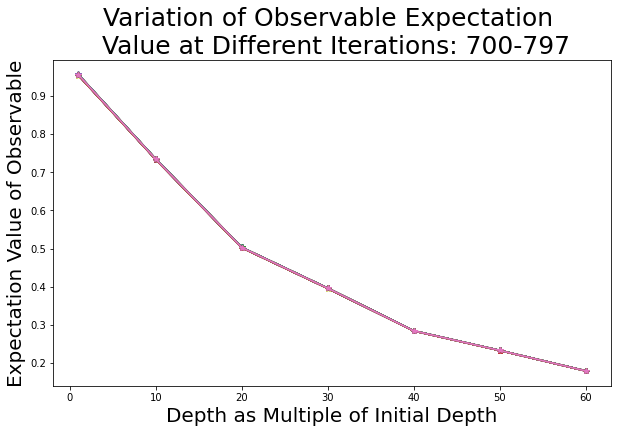

In [49]:
# s1 = scaled_exp_dict_for_diff_iterations[364]['XXIIII'][1:]
# s2 = scaled_exp_dict_for_diff_iterations[365]['XXIIII'][1:]
# s3 = scaled_exp_dict_for_diff_iterations[366]['XXIIII'][1:]
# s4 = scaled_exp_dict_for_diff_iterations[367]['XXIIII'][1:]

# plt.plot(list(range(len(s1))), s1, marker = '*', label = '-1')
# plt.plot(list(range(len(s2))), s2, marker = 'd', label = '-2')
# plt.plot(list(range(len(s3))), s3, marker = 'o', label = '-3')
# plt.plot(list(range(len(s4))), s4, marker = 'o', label = '-4')

plt.figure(figsize = (10, 6))
total_num_points = len(scaled_exp_dict_for_diff_iterations)
n = 7
_p_idx = 92
for i in range(n*100, total_num_points, 1):
    si = scaled_exp_dict_for_diff_iterations[i][paulis[_p_idx]][1:]
    plt.plot(scales, si, marker = '*', label = i)

#plt.legend(bbox_to_anchor = (1 ,1))
plt.ylabel('Expectation Value of Observable', fontsize = 20)
plt.xlabel('Depth as Multiple of Initial Depth', fontsize = 20)
plt.title('Variation of Observable Expectation \n Value at Different Iterations: 700-797', fontsize = 25)

In [ ]:
plt.figure(figsize = (10, 6))
p_op = 'IIXXII'
for i in range(350):
    si = scaled_exp_dict_for_diff_iterations[i][p_op][1:]
    pi = scaled_exp_dict_for_diff_iterations[i][p_op][0]
    plt.plot(scales, si, marker = '*', label = i)
    plt.plot([0], pi, marker = 'd', label = 'ideal_value_' + str(i))

plt.legend(bbox_to_anchor = (1 ,1))

### Save the data for temporal evaluation ###

In [24]:
parent_folder = '/u/vqezne/Internship/ZNE experiments/Experiment 4/'
device_name = 'fake_mumbai'
workload_name = 'CH4-AS3'
date = '19072023'

#pickle.dump(all_init_points, open(parent_folder + device_name + '/' + workload_name + '/' + 'all_init_points_' + date + '_.pkl', 'wb'))
#pickle.dump(scaled_exp_dict_for_diff_iterations, open(parent_folder + device_name + '/' + workload_name + '/' + 'scaled_exp_dict_for_diff_iterations_' + date + '_.pkl', 'wb'))
#pickle.dump({'paulis': paulis, 'coeffs': coeffs}, open(parent_folder + device_name + '/' + workload_name + '/' + 'paulis_and_coeffs_' + date + '_.pkl', 'wb'))

In [25]:
import pickle
sc = pickle.load(open(parent_folder + device_name + '/' + workload_name + '/' + 'scaled_exp_dict_for_diff_iterations_' + date + '_.pkl', 'rb'))

In [26]:
scaled_exp_dict_for_diff_iterations = sc

### Variation of Spatial Trends Over Time ###

In [ ]:
plt.figure(figsize = (20, 6))
plt.plot(list(range(len(loss_vals))), loss_vals, marker = '*')

In [19]:
scales = [1, 10, 20, 30, 40, 50, 60]

Text(0.5, 1.0, 'Variation of Observable Expectation \n Value with Circuit')

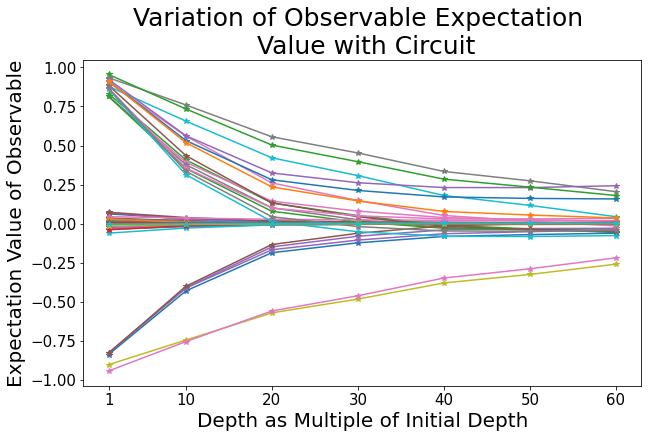

In [52]:
import matplotlib.pyplot as plt

# initialization index (different indices correpond to different initialization points)
i = len(scaled_exp_dict_for_diff_iterations) - 1

# The pauli index
plt.figure(figsize = (10, 6))
for p0 in range(0, len(paulis), 1):
    #print(paulis[p0])
    relevant_exp_vals = scaled_exp_dict_for_diff_iterations[i][paulis[p0]]
    plt.plot(scales, relevant_exp_vals[1:], marker = '*', label = paulis[p0])
    plt.xticks(scales, fontsize = 15)
    plt.yticks(fontsize = 15)
    #plt.plot([0], relevant_exp_vals[0], marker = 'd')

#plt.legend(bbox_to_anchor = (1 ,1))
plt.ylabel('Expectation Value of Observable', fontsize = 20)
plt.xlabel('Depth as Multiple of Initial Depth', fontsize = 20)
plt.title('Variation of Observable Expectation \n Value with Circuit', fontsize = 25)

### See patterns in spatial variation with time ###

In [21]:
# create dictionary with (pauli1, pauli2) pairs as keys. 
# The value is a list which contains correlation between
# pauli1, pauli 2 trends (we could also record the a,b,c parameters)
# We want to see how this correlation varies with iterations

import mitiq

parent_folder = '/u/vqezne/Internship/ZNE experiments/Experiment 4/'
device_name = 'fake_mumbai'
workload_name = 'CH4-AS2'
date = '19072023'

scaled_exp_dict_for_diff_iterations = pickle.load(open(parent_folder + device_name + '/' + workload_name + '/' + 'scaled_exp_dict_for_diff_iterations_' + date + '_.pkl', 'rb'))
iterations = list(scaled_exp_dict_for_diff_iterations.keys())
paulis = list(scaled_exp_dict_for_diff_iterations[0].keys())

# correlation metric
all_correlations_across_iterations = {}
for i in range(len(paulis)):
    for j in range(i+1, len(paulis)):
        all_correlations_across_iterations[(paulis[i], paulis[j])] = []
        
# (a,b,c) metric
all_coeffs_across_iterations = {}
for pauli_idx, pauli_op in enumerate(paulis):
    all_coeffs_across_iterations[pauli_op] = []
    
# the exponential factory that we will use
scales = [1, 10, 20, 30, 40, 50, 60]
exp_factory = mitiq.zne.inference.ExpFactory(scale_factors = scales, asymptote=None, avoid_log=False, shot_list=None)

# record the correlations with time
for iter_num in iterations:
    
    # get the expectations data for that iteration
    exp_data_for_iteration = scaled_exp_dict_for_diff_iterations[iter_num]
    
    for pidx1 in range(len(paulis)):
        for pidx2 in range(pidx1+1, len(paulis)):
            
            # get hold of the trends
            t1 = exp_data_for_iteration[paulis[pidx1]]
            t2 = exp_data_for_iteration[paulis[pidx2]]
            
            # get only the real parts
            t1 = [val.real for val in t1]
            t2 = [val.real for val in t2]
            
            # compute correlation
            corr = pearsonr(t1, t2)
            all_correlations_across_iterations[(paulis[pidx1], paulis[pidx2])].append(corr[0])
    
    for pidx, pauli_op in enumerate(paulis):
        
        trend = exp_data_for_iteration[pauli_op]
        trend = [val.real for val in trend][1:]
        
        #output = exp_factory.extrapolate(scales, trend, full_output = True)
        #all_coeffs_across_iterations[pauli_op].append([output[0], output[2]])
        
        #get the extrapolation co-efficients for the given curve
        try:
            output = exp_factory.extrapolate(scales, trend, full_output = True)
            all_coeffs_across_iterations[pauli_op].append([output[0], output[2]])
        except:
            all_coeffs_across_iterations[pauli_op].append(['n', ('n','n','n')])

/u/vqezne/.conda/envs/qiskit_runtime_2/lib/python3.8/site-packages/mitiq/zne/inference.py:1366: RuntimeWarning: overflow encountered in exp
  return coeffs[0] + coeffs[1] * np.exp(x * np.polyval(z_coeffs, x))
/u/vqezne/.conda/envs/qiskit_runtime_2/lib/python3.8/site-packages/mitiq/zne/inference.py:1366: RuntimeWarning: overflow encountered in exp
  return coeffs[0] + coeffs[1] * np.exp(x * np.polyval(z_coeffs, x))
/u/vqezne/.conda/envs/qiskit_runtime_2/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: ExtrapolationWarning: The extrapolation fit may be ill-conditioned. Likely, more data points are necessary to fit the parameters of the model.
  warnings.warn('Covariance of the parameters could not be estimated',
/u/vqezne/.conda/envs/qiskit_runtime_2/lib/python3.8/site-packages/mitiq/zne/inference.py:1366: RuntimeWarning: overflow encountered in exp
  return coeffs[0] + coeffs[1] * np.exp(x * np.polyval(z_coeffs, x))
/u/vqezne/.conda/envs/qiskit_runtime_2/lib/python3.8/site

KeyboardInterrupt: 

In [ ]:
all_keys = list(all_correlations_across_iterations.keys())
k_idx = 321
key_in_use = all_keys[k_idx]
correlation_trend = all_correlations_across_iterations[key_in_use]

print(key_in_use)
plt.figure(figsize = (20, 6))
plt.plot(list(range(len(correlation_trend))), correlation_trend, label = key_in_use[0] + '-' + key_in_use[1])

In [ ]:
all_coeffs_across_iterations

In [ ]:
all_keys = list(all_correlations_across_iterations.keys())
k_idx = 2
key_in_use = all_keys[k_idx]

trend0 = all_coeffs_across_iterations[key_in_use[0]]
a0 = [v[1][0] for v in trend0]
b0 = [v[1][1] for v in trend0]
c0 = [v[1][2] for v in trend0]

trend1 = all_coeffs_across_iterations[key_in_use[1]]
a1 = [v[1][0] for v in trend1]
b1 = [v[1][1] for v in trend1]
c1 = [v[1][2] for v in trend1]

#print(c0, c1)

print(key_in_use)
plt.figure(figsize = (20, 6))
plt.plot(list(range(len(c0))), a0, label = key_in_use[0])
plt.plot(list(range(len(c1))), a1, label = key_in_use[1])
plt.legend()

### Testing the internal ZNE functionalities of Qiskit Runtime and if that does well ###

In [11]:
# General imports
import time
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# The IBM Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Session

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

In [5]:
service = QiskitRuntimeService()

In [7]:
backend = service.get_backend("ibmq_qasm_simulator")

In [16]:
hamiltonian_string = '/u/vqezne/Internship/VarSaw/vqe-term-grouping-master/hamiltonians/CH4_sto-3g_BK_grnd_AS3.txt'
hamiltonian_string_elements = hamiltonian_string.split('/')
hamil = parseHamiltonian(hamiltonian_string)

#get the number of qubits in the hamiltonian
max_length = 0
for i in hamil:
    if int(i[1][-1][1]) + 1 > max_length:
        max_length = int(i[1][-1][1]) + 1

#Number of qubits in the hamiltonian
n_qubits = max_length

# number of repetitions
p = 1

#get paulis and coefficients
coeffs, paulis = give_paulis_and_coeffs(hamil, n_qubits)
n_terms = len(paulis)
paulis = paulis[1:n_terms]
coeffs = coeffs[1:n_terms]

hamiltonian_list = []
for pauli_el_idx, pauli_el in enumerate(paulis):
    hamiltonian_list.append((pauli_el, coeffs[pauli_el_idx]))

hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

In [18]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
num_params = ansatz.num_parameters

In [20]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    energy = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return energy

In [21]:
np.random.seed(0)
x0 = 2 * np.pi * np.random.random(num_params)

In [ ]:
options = Options()
options.execution.shots = 1000
options.optimization_level = 0  # No optimization
options.resilience_level = 2  # ZNE
estimator = Estimator()

spsa = SPSA(maxiter = 5000)
objective_function = lambda c: cost_function(c, ansatz, hamiltonian, )
vqe_result = spsa.optimize(num_vars = 2*n_qubits*(p+1), objective_function = objective_function, variable_bounds = bounds, initial_point = initial_point)
